<a href="https://colab.research.google.com/github/ridhsk/DeepFake-Detection/blob/main/models/EfficientNet-B3/15frames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  !pip uninstall -y pandas
!pip install pandas --no-cache-dir --upgrade

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 161.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [ ]:
!pip install tensorflow opencv-python mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy

# ✅ Mixed precision enabled
set_global_policy('mixed_float16')

# ✅ Paths
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/Nagashree"
CHECKPOINT_DIR = os.path.join(DATASET_DIR, "EfficientNetB3.2", "checkpoints")
MANUAL_CHECKPOINT = os.path.join(CHECKPOINT_DIR, "efficientnetb3_epoch_05_valacc_0.9103.keras")
FINETUNED_MODEL_PATH = os.path.join(DATASET_DIR, "EfficientNetB3.2", "efficientnetb3_finetuned_model.keras")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ✅ Constants
IMG_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 30
INITIAL_EPOCH = 5  # Resuming from epoch 6

# ✅ Data generators
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['real', 'fake'],
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['real', 'fake'],
    shuffle=False
)

# ✅ Custom Cast layer with unique name
class Cast(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        name = name or f"cast_{np.random.randint(1e6)}"
        super(Cast, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        return inputs

    def get_config(self):
        config = super(Cast, self).get_config()
        return config

# ✅ Load checkpoint
print(f"🔁 Loading checkpoint: {MANUAL_CHECKPOINT}")
model = tf.keras.models.load_model(MANUAL_CHECKPOINT, custom_objects={"Cast": Cast})

# ✅ Recompile model
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# ✅ Callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'efficientnetb3_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.keras'),
    save_best_only=False,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# ✅ Compute class weights
from sklearn.utils import class_weight
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

# ✅ Show GPU info (optional)
!nvidia-smi

# ✅ Resume training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# ✅ Save final fine-tuned model
model.save(FINETUNED_MODEL_PATH)
print(f"\n✅ Fine-tuned model saved to: {FINETUNED_MODEL_PATH}")


Found 11996 images belonging to 2 classes.
Found 2998 images belonging to 2 classes.
🔁 Loading checkpoint: /content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/checkpoints/efficientnetb3_epoch_05_valacc_0.9103.keras
Wed Jul 16 13:36:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9713 - auc: 0.9971 - loss: 0.0641
Epoch 6: saving model to /content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/checkpoints/efficientnetb3_epoch_06_valacc_0.9106.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 3552s 9s/step - accuracy: 0.9713 - auc: 0.9971 - loss: 0.0641 - val_accuracy: 0.9106 - val_auc: 0.9681 - val_loss: 0.2768 - learning_rate: 1.0000e-05
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.9666 - auc: 0.9964 - loss: 0.0750
Epoch 7: saving model to /content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/checkpoints/efficientnetb3_epoch_07_valacc_0.9096.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 369s 985ms/step - accuracy: 0.9666 - auc: 0.9964 - loss: 0.0750 - val_accuracy: 0.9096 - val_auc: 0.9744 - val_loss: 0.2339 - learning_rate: 1.0000e-05
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.9722 - auc: 0.9976 - loss: 0.0614
Epoch 8: saving model to /content/dri

In [ ]:

!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Found 14994 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 160s 318ms/step

📊 Classification Report:

              precision    recall  f1-score   support

        real       0.96      0.98      0.97      7500
        fake       0.98      0.96      0.97      7494

    accuracy                           0.97     14994
   macro avg       0.97      0.97      0.97     14994
weighted avg       0.97      0.97      0.97     14994


🔍 Confusion Matrix:
 [[7360  140]
 [ 288 7206]]


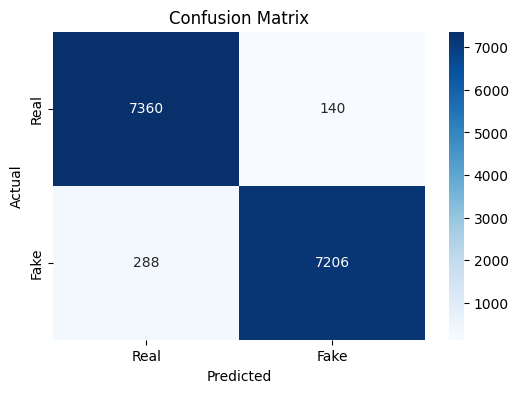

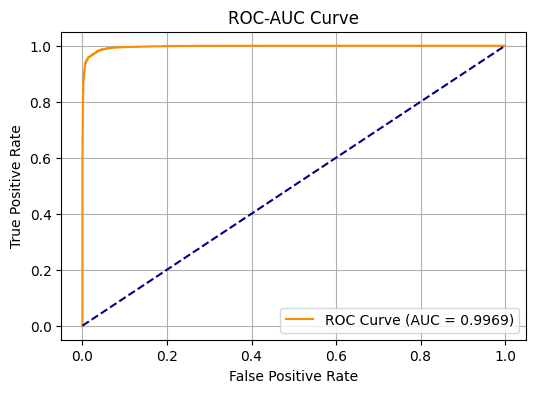

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# ✅ Paths
IMG_SIZE = 300
BATCH_SIZE = 32
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/Nagashree"
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/efficientnetb3_finetuned_model.keras"

# ✅ Custom Cast layer
class Cast(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        name = name or f"cast_eval_{np.random.randint(1e6)}"
        super(Cast, self).__init__(name=name, **kwargs)
    def call(self, inputs):
        return inputs
    def get_config(self):
        return super().get_config()

# ✅ Load model
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"Cast": Cast})

# ✅ Load full data from 'fake' and 'real' folders
eval_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

eval_generator = eval_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=['real', 'fake']  # IMPORTANT: Ensure correct label order
)

# ✅ True and predicted values
y_true = eval_generator.classes
y_pred_proba = model.predict(eval_generator, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# ✅ Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['real', 'fake']))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\n🔍 Confusion Matrix:\n", cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Found 2998 images belonging to 2 classes.
94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 911ms/step

🔍 Evaluation Metrics on Validation Data:
Accuracy:  0.9149
Precision: 0.9361
Recall:    0.8905
F1 Score:  0.9128
ROC AUC:   0.9755


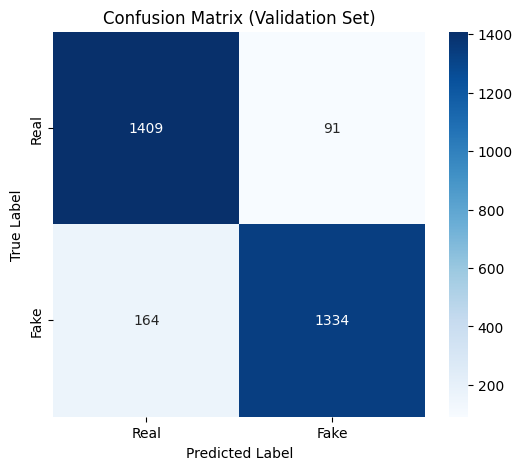

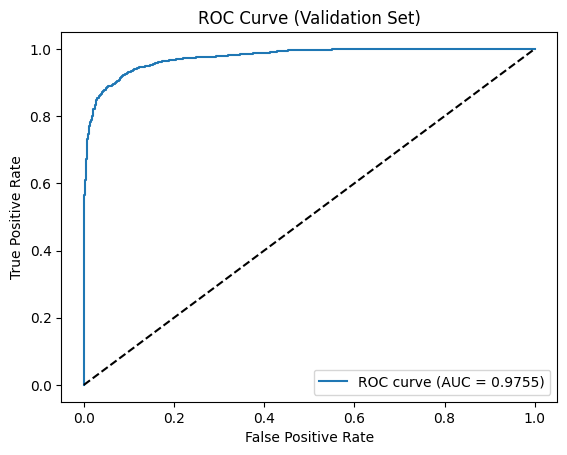

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
import seaborn as sns
from keras.saving import register_keras_serializable

# ✅ Paths
IMG_SIZE = 300
BATCH_SIZE = 32
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/Nagashree"
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/efficientnetb3_finetuned_model.keras"

# ✅ Define and Register Custom Cast Layer
@register_keras_serializable()
class Cast(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        name = name or f"cast_eval_{np.random.randint(1e6)}"
        super(Cast, self).__init__(name=name, **kwargs)
    def call(self, inputs):
        return inputs
    def get_config(self):
        return super().get_config()

# ✅ Load Model
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"Cast": Cast})

# ✅ ImageDataGenerator with Validation Split
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

# ✅ Validation Generator (20% of dataset)
val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    subset='validation',
    classes=['real', 'fake']  # Ensure correct label order
)

# ✅ Get true and predicted values
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# ✅ Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

print("\n🔍 Evaluation Metrics on Validation Data:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# ✅ ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy

# ✅ Mixed precision enabled
set_global_policy('mixed_float16')

# ✅ Paths
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/Nagashree"
FINETUNED_MODEL_INPUT = os.path.join(DATASET_DIR, "EfficientNetB3.2", "efficientnetb3_finetuned_model.keras")
CHECKPOINT_DIR = os.path.join(DATASET_DIR, "EfficientNetB3.2", "checkpoints_finetune")
FINETUNED_MODEL_OUTPUT = os.path.join(DATASET_DIR, "EfficientNetB3.2", "efficientnetb3_finetuned_again.keras")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ✅ Constants
IMG_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 30

# ✅ Data generators (using real/ and fake/)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['real', 'fake'],
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['real', 'fake'],
    shuffle=False
)

# ✅ Custom Cast layer to avoid duplicate name errors
class Cast(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        name = name or f"cast_{np.random.randint(1e6)}"
        super(Cast, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        return inputs

    def get_config(self):
        return super().get_config()

# ✅ Load saved model (not from checkpoint)
print(f"🔁 Loading saved model for fine-tuning: {FINETUNED_MODEL_INPUT}")
model = load_model(FINETUNED_MODEL_INPUT, custom_objects={'Cast': Cast})

# ✅ Recompile model
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# ✅ Callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'finetuned_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.keras'),
    save_best_only=False,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# ✅ Compute class weights
from sklearn.utils import class_weight
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

# ✅ Optional: Show GPU info
!nvidia-smi

# ✅ Fine-tune from scratch
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# ✅ Save final fine-tuned model
model.save(FINETUNED_MODEL_OUTPUT)
print(f"\n✅ Fine-tuned model saved to: {FINETUNED_MODEL_OUTPUT}")


Found 11996 images belonging to 2 classes.
Found 2998 images belonging to 2 classes.
🔁 Loading saved model for fine-tuning: /content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/efficientnetb3_finetuned_model.keras
Sun Jul 20 16:29:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9739 - auc: 0.9975 - loss: 0.0614
Epoch 1: saving model to /content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/checkpoints_finetune/finetuned_epoch_01_valacc_0.9079.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 3241s 8s/step - accuracy: 0.9739 - auc: 0.9975 - loss: 0.0614 - val_accuracy: 0.9079 - val_auc: 0.9720 - val_loss: 0.2683 - learning_rate: 1.0000e-05
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9733 - auc: 0.9972 - loss: 0.0637
Epoch 2: saving model to /content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/checkpoints_finetune/finetuned_epoch_02_valacc_0.8993.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 371s 991ms/step - accuracy: 0.9733 - auc: 0.9972 - loss: 0.0637 - val_accuracy: 0.8993 - val_auc: 0.9668 - val_loss: 0.2852 - learning_rate: 1.0000e-05
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9733 - auc: 0.9978 - loss: 0.0575
Epoch 3: saving model to /con

Found 2998 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 90s 854ms/step

🔍 Evaluation Metrics on Validation Data:
Accuracy:  0.9229
Precision: 0.9378
Recall:    0.9059
F1 Score:  0.9216
ROC AUC:   0.9779


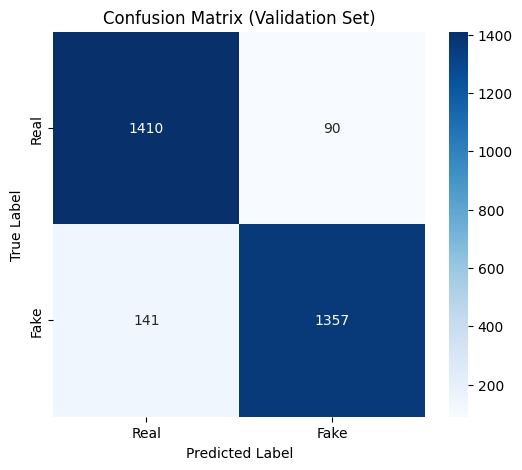

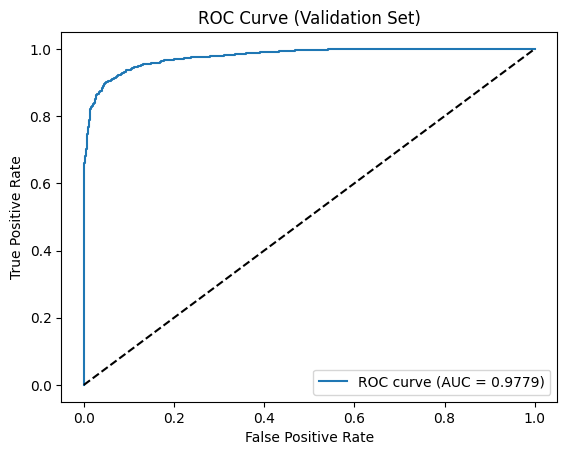

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
import seaborn as sns
from keras.saving import register_keras_serializable

# ✅ Paths
IMG_SIZE = 300
BATCH_SIZE = 32
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/Nagashree"
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/efficientnetb3_finetuned_again.keras"

# ✅ Define and Register Custom Cast Layer
@register_keras_serializable()
class Cast(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        name = name or f"cast_eval_{np.random.randint(1e6)}"
        super(Cast, self).__init__(name=name, **kwargs)
    def call(self, inputs):
        return inputs
    def get_config(self):
        return super().get_config()

# ✅ Load Model
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"Cast": Cast})

# ✅ ImageDataGenerator with Validation Split
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

# ✅ Validation Generator (20% of dataset)
val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    subset='validation',
    classes=['real', 'fake']  # Ensure correct label order
)

# ✅ Get true and predicted values
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# ✅ Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

print("\n🔍 Evaluation Metrics on Validation Data:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# ✅ ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.utils import class_weight

# ✅ Enable mixed precision
set_global_policy('mixed_float16')

# ✅ Paths
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/Nagashree"
MODEL_OUTPUT = os.path.join(DATASET_DIR, "EfficientNetB3.2", "efficientnetb3_finetuned111111.keras")
CHECKPOINT_DIR = os.path.join(DATASET_DIR, "EfficientNetB3.2", "checkpoints_finetune")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ✅ Constants
IMG_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 30

# ✅ Data generators
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['real', 'fake'],
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['real', 'fake'],
    shuffle=False
)

# ✅ Define custom Cast layer with unique name
@tf.keras.utils.register_keras_serializable()
class Cast(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        if name is None:
            name = f"cast_{np.random.randint(1e6)}"
        super(Cast, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        return inputs

    def get_config(self):
        config = super().get_config()
        return config

# ✅ Build model from scratch using EfficientNetB3
base_model = EfficientNetB3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Cast()(x)  # Ensure single usage
output = Dense(1, activation='sigmoid', dtype='float32')(x)  # float32 output

model = Model(inputs=base_model.input, outputs=output)

# ✅ Compile model
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# ✅ Callbacks
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.keras'),
    save_best_only=False,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# ✅ Compute class weights
labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

# ✅ Start training from epoch 0
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# ✅ Save the final model
model.save(MODEL_OUTPUT)
print(f"\n✅ Model saved at: {MODEL_OUTPUT}")


Found 11996 images belonging to 2 classes.
Found 2998 images belonging to 2 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6021 - auc: 0.6411 - loss: 0.8279 
Epoch 1: saving model to /content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/checkpoints_finetune/epoch_01_valacc_0.8149.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 5216s 13s/step - accuracy: 0.6024 - auc: 0.6414 - loss: 0.8275 - val_accuracy: 0.8149 - val_auc: 0.9133 - val_loss: 0.4040 - learning_rate: 1.0000e-05
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.8286 - auc: 0.9116 - loss: 0.3888
Epoch 2: saving model to /content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/checkpoints_finetune/epoch_02_valacc_0.8729.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.8286 - auc: 0.9116 - loss: 0.3887 - val_accuracy: 0.8729 - val_auc: 0.9537 - val_loss: 0.3008 - learning_rate: 1.0000e-05
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.8919 - auc: 0.9603 - loss: 0.2621
Epoch 3: saving model to /content/drive/MyDrive/D

Found 2998 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 93s 875ms/step

🔍 Evaluation Metrics on Validation Data:
Accuracy:  0.9383
Precision: 0.9305
Recall:    0.9473
F1 Score:  0.9388
ROC AUC:   0.9891


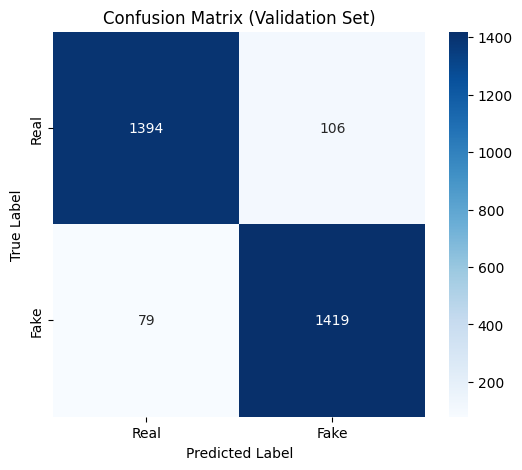

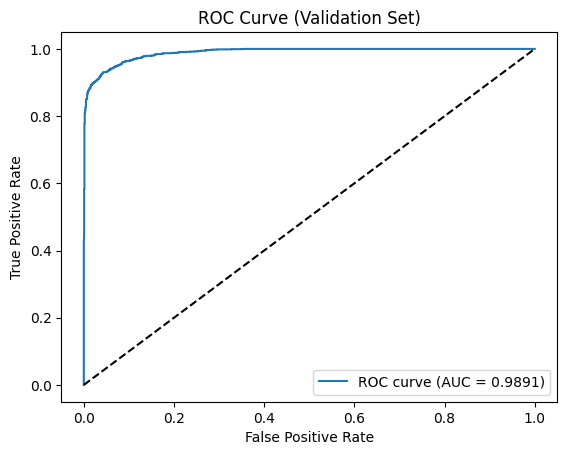

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
import seaborn as sns
from keras.saving import register_keras_serializable

# ✅ Paths
IMG_SIZE = 300
BATCH_SIZE = 32
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/Nagashree"
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/efficientnetb3_finetuned111111.keras"

# ✅ Define and Register Custom Cast Layer
@register_keras_serializable()
class Cast(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        name = name or f"cast_eval_{np.random.randint(1e6)}"
        super(Cast, self).__init__(name=name, **kwargs)
    def call(self, inputs):
        return inputs
    def get_config(self):
        return super().get_config()

# ✅ Load Model
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"Cast": Cast})

# ✅ ImageDataGenerator with Validation Split
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

# ✅ Validation Generator (20% of dataset)
val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    subset='validation',
    classes=['real', 'fake']  # Ensure correct label order
)

# ✅ Get true and predicted values
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# ✅ Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

print("\n🔍 Evaluation Metrics on Validation Data:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# ✅ ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 686 variables whereas the saved optimizer has 690 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2998 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 739s 8s/step

🔍 Evaluation Metrics on Validation Data:
Accuracy:         0.9383
Precision:        0.9305
Recall:           0.9473
F1 Score:         0.9388
ROC AUC:          0.9891
AUPRC:            0.9897
Log Loss:         0.1498
MCC:              0.8767
EER:              0.0593 (Threshold: 0.5750)
False Positive Rate: 0.0707
False Negative Rate: 0.0527


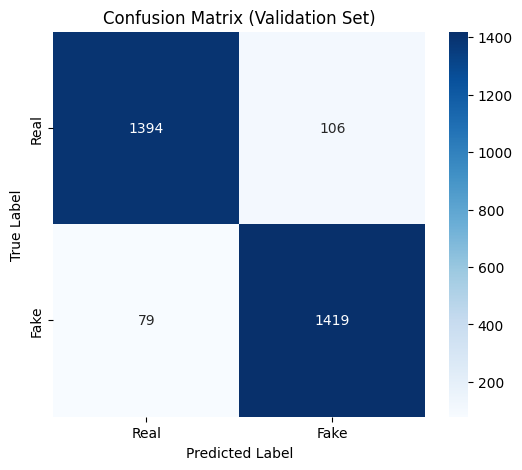

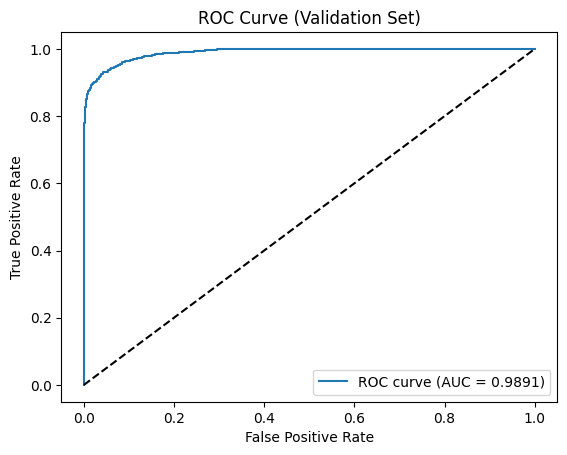

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, log_loss, matthews_corrcoef
)
import seaborn as sns
from keras.saving import register_keras_serializable

# === Paths ===
IMG_SIZE = 300
BATCH_SIZE = 32
DATASET_DIR = "/content/drive/MyDrive/DeepFake Detection/Nagashree"
MODEL_PATH = "/content/drive/MyDrive/DeepFake Detection/Nagashree/EfficientNetB3.2/efficientnetb3_finetuned111111.keras"

# === Custom Cast Layer ===
@register_keras_serializable()
class Cast(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        name = name or f"cast_eval_{np.random.randint(1e6)}"
        super(Cast, self).__init__(name=name, **kwargs)
    def call(self, inputs):
        return inputs
    def get_config(self):
        return super().get_config()

# === Load Model ===
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"Cast": Cast})

# === Validation Data Generator ===
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    subset='validation',
    classes=['real', 'fake']
)

# === Predictions ===
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# === Basic Metrics ===
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# === Extra Metrics ===
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
auprc = auc(recall_vals, precision_vals)  # Area under precision-recall curve
logloss = log_loss(y_true, y_pred_prob)   # Log loss
mcc = matthews_corrcoef(y_true, y_pred)   # Matthews correlation coefficient

# Equal Error Rate (EER)
fpr_vals, tpr_vals, thresholds = roc_curve(y_true, y_pred_prob)
fnr = 1 - tpr_vals
eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr_vals))]
eer = fpr_vals[np.nanargmin(np.absolute(fnr - fpr_vals))]

# False Positive Rate (FPR) & False Negative Rate (FNR)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr_value = fp / (fp + tn)
fnr_value = fn / (fn + tp)

# === Print All Metrics ===
print("\n🔍 Evaluation Metrics on Validation Data:")
print(f"Accuracy:         {acc:.4f}")
print(f"Precision:        {prec:.4f}")
print(f"Recall:           {rec:.4f}")
print(f"F1 Score:         {f1:.4f}")
print(f"ROC AUC:          {roc_auc:.4f}")
print(f"AUPRC:            {auprc:.4f}")
print(f"Log Loss:         {logloss:.4f}")
print(f"MCC:              {mcc:.4f}")
print(f"EER:              {eer:.4f} (Threshold: {eer_threshold:.4f})")
print(f"False Positive Rate: {fpr_value:.4f}")
print(f"False Negative Rate: {fnr_value:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# === ROC Curve ===
plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
